## Задание 09
В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. 
Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones).  Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице. 

Мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. 

* Скачайте данные самостоятельно. Объедините тестовую и обучающую выборку в одну (для задачи кластеризации тестовая выборка не понадобится). 

In [59]:
import numpy as np
import pandas as pd

def transform(X, t=float, feat =None):
    l2 = set([''])
    tmp = []
    for i in X:
        i = tmp.append(list(filter(lambda x: x not in l2, i.split(' '))))
    if(feat is not None):
        return pd.DataFrame(np.array(tmp), columns=feat).astype(t)
    else:
        return pd.DataFrame(np.array(tmp)).astype(t)

    
dataX_train = np.loadtxt("C:/Users/corsa/Desktop/X_train.txt", delimiter=' \n', dtype=str)
dataY_train = np.loadtxt("C:/Users/corsa/Desktop/y_train.txt", delimiter=' \n', dtype=str)
dataX_test  = np.loadtxt("C:/Users/corsa/Desktop/X_test.txt", delimiter=' \n', dtype=str)
dataY_test  = np.loadtxt("C:/Users/corsa/Desktop/y_test.txt", delimiter=' \n', dtype=str)

features = np.loadtxt("C:/Users/corsa/Desktop/UCI HAR Dataset/features.txt", delimiter = ' \n', dtype=str)
features = transform(features, t=str).loc[:,1].values

X_train = transform(dataX_train, feat = features)
X_test  = transform(dataX_test, feat = features)
y_train = transform(dataY_train)[0]
y_test  = transform(dataY_test)[0]

X = pd.concat([X_train, X_test], axis=0)
Y = pd.concat([y_train, y_test], axis=0)

10299

* Определите число уникальных значений меток целевого класса. Будем использовать это значения для числа кластеров (в общем случае, число кластеров, мы естественно не знаем). 

In [60]:
len(set(Y))

6

* Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [62]:
from sklearn.preprocessing import StandardScaler

scl = StandardScaler()
X_scaled = scl.fit_transform(X)

* С помощью PCA, оставьте столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

In [86]:
from sklearn.decomposition import PCA

prev = 1.0
for i in range(X_scaled.shape[1]):
    pca = PCA(n_components=X_scaled.shape[1]-i-1)
    pca.fit(X_scaled.T)
    cur = sum(pca.explained_variance_ratio_)
    if(cur<0.9):
        print('number of features', X_scaled.shape[1]-i, "prev", prev)
        break
    prev = cur

number of features 82 prev 0.9000291024950668


Необходимо минимум 82 компоненты

* Сколько процентов дисперсии приходится на первую главную компоненту?

In [87]:
pca = PCA(n_components=82)
pca.fit(X_scaled.T)
print("Первая компонента объясняет",pca.explained_variance_ratio_[0]*100,"%")

Первая компонента объясняет 34.49536855285394 %


* Визуализируйте данные в проекции на первые две главные компоненты.

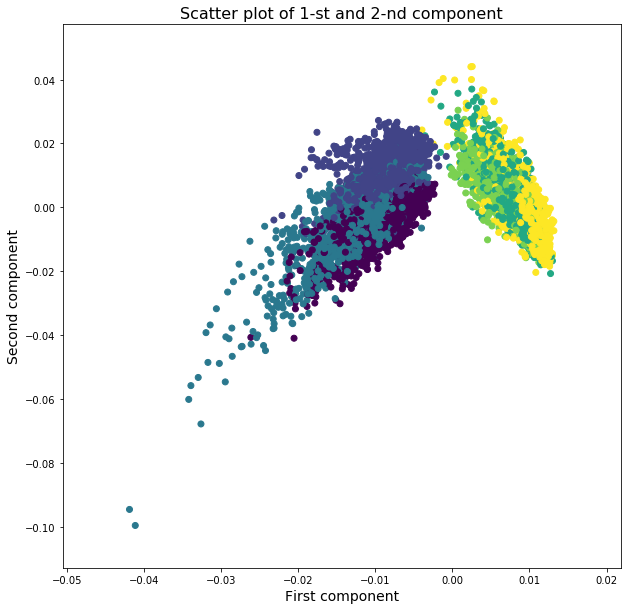

In [123]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
plt.scatter(pca.components_[0,:], pca.components_[1,:],c=Y)
plt.xlabel("First component", fontsize=14)
plt.ylabel("Second component", fontsize=14)
plt.title("Scatter plot of 1-st and 2-nd component", fontsize=16)
plt.show()

* Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет PCA размерностью.  

In [96]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=len(set(Y)), random_state=1648).fit(pca.components_.T)

* Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

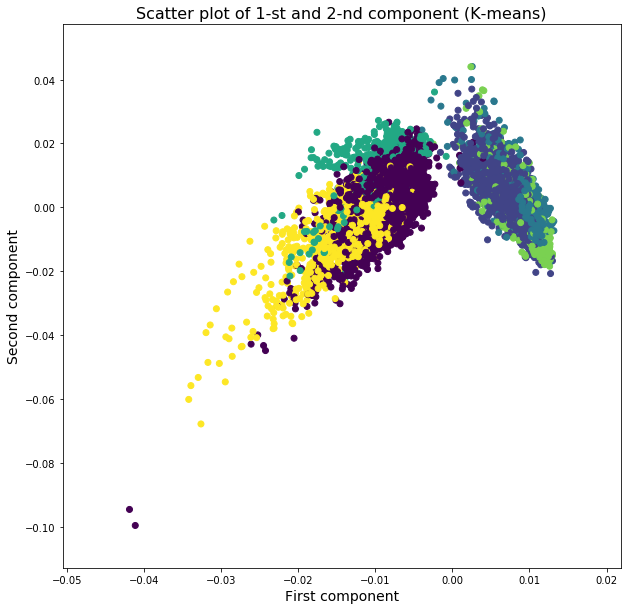

In [126]:
fig = plt.figure(figsize=(10,10))
plt.scatter(pca.components_[0,:], pca.components_[1,:], c=kmeans.labels_)
plt.xlabel("First component", fontsize=14)
plt.ylabel("Second component", fontsize=14)
plt.title("Scatter plot of 1-st and 2-nd component (K-means)", fontsize=16)
plt.show()

* Сделайте кластеризацию с помощью агломеративного метода. 

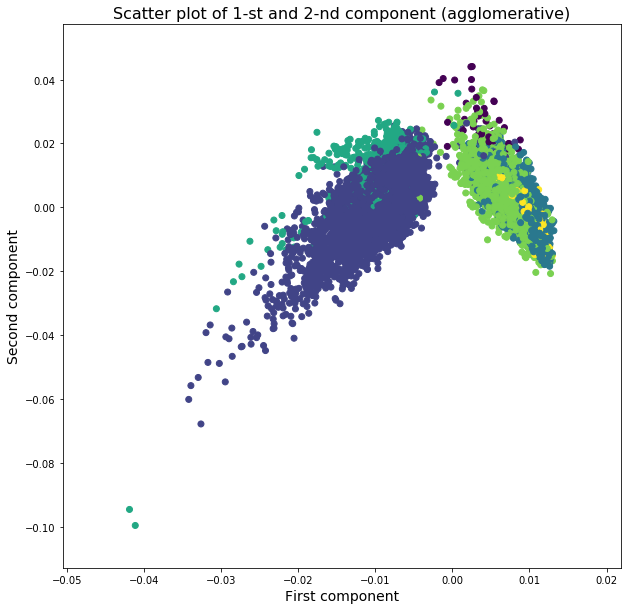

In [125]:
from sklearn.cluster import AgglomerativeClustering

ag = AgglomerativeClustering(n_clusters=len(set(Y)), 
                             linkage='ward').fit(pca.components_.T)

fig = plt.figure(figsize=(10,10))
plt.scatter(pca.components_[0,:], pca.components_[1,:], c=ag.labels_)
plt.xlabel("First component", fontsize=14)
plt.ylabel("Second component", fontsize=14)
plt.title("Scatter plot of 1-st and 2-nd component (agglomerative)", fontsize=16)
plt.show()

* Cравните работу двух алгоритмов по значениям [Adjusted Rand Index (ARI)](https://en.wikipedia.org/wiki/Rand_index).

**Adjusted Rand Index (ARI)**

Предполагается, что известны истинные метки объектов. Данная мера не зависит от самих значений меток, а только от разбиения выборки на кластеры. Пусть $N$ - число объектов в выборке. Обозначим через $a$ - число пар объектов, имеющих одинаковые метки и находящихся в одном кластере, через $b$ - число пар объектов, имеющих различные метки и находящихся в разных кластерах. Тогда Rand Index это $$\text{RI} = \frac{2(a + b)}{n(n-1)}.$$ То есть это доля объектов, для которых эти разбиения (исходное и полученное в результате кластеризации) "согласованы". Rand Index (RI) выражает схожесть двух разных кластеризаций одной и той же выборки. Чтобы этот индекс давал значения близкие к нулю для случайных кластеризаций при любом $N$ и числе кластеров, необходимо нормировать его. Так определяется Adjusted Rand Index: $$\text{ARI} = \frac{\text{RI} - E[\text{RI}]}{\max(\text{RI}) - E[\text{RI}]}.$$

Эта мера симметрична, не зависит от значений и перестановок меток. Таким образом, данный индекс является мерой расстояния между различными разбиениями выборки. $\text{ARI}$ принимает значения в диапазоне $[-1, 1]$. Отрицательные значения соответствуют "независимым" разбиениям на кластеры, значения, близкие к нулю, - случайным разбиениям, и положительные значения говорят о том, что два разбиения схожи (совпадают при $\text{ARI} = 1$).

In [106]:
from sklearn.metrics.cluster import adjusted_rand_score

In [120]:
#adjusted_rand_score()
km_preds = kmeans.predict(pca.components_.T)
ag_preds = ag.fit_predict(pca.components_.T) 

print("K_mean score", adjusted_rand_score(Y, km_preds))
print("Agglomeravive score", adjusted_rand_score(Y, ag_preds))

K_mean score 0.5498216850821684
Agglomeravive score 0.45221270610946385


Из того, что значения в обоих случаях положительные, то делаем вывод, что оба метода разбили отшкалированные данные на кластеры близкие к тем, которые являются целевыми, при этом метод к-средних проявил себя нексолкько лучше, потому, что для него значение ARI ближе к 1, чем для иерархичекого метода кластеризации.